# 线性回归
- 线性回归基于几个假设：自变量X和因变量y之间的关系是线性的，即y可以表述成X中元素的加权和，这里通常允许包含观测值的一些噪声；其次假设任何噪声都比较正常，服从正态分布
- 用数学来表达是： y=w1x1+w2x2+w3x3+...+b其中wi是权重，xi是输入，b是偏置
- 我们需要一种度量模型优劣的方法和一种提高模型预测质量的方法，也就是损失函数和优化器
- 损失函数：线性函数拟合程度的一个度量，能够量化目标的实际值与预测值之间的差距，一般在回归中都采用均方误差，它求导之后是1：l(w,b)=0.5*(y_pred-y_label)^2。在训练模型的时候，我们希望找到一组w和b使l最小
- 解析解：线性回归的解可以用一个公式简单地表达出来，这类解叫做解析解analytical solution，但是并不是所有的问题都存在解析解。
- 随机梯度下降：它几乎可以优化所有的深度学习模型，梯度下降的最简单用法就是计算损失函数关于模型参数的导数（称为梯度）
- 超参数：可以调整，不在训练过程中更新的参数成为超参数
- 调参：调整超参数使得模型性能更好

In [2]:
%matplotlib inline

import torch as t
import sys
sys.path.append("../")
from pltutils import *
import pltutils
import random

In [3]:
#生成噪声
def synthetic_data(w: t.Tensor, b: float, num_examples: int):
    x = t.normal(0, 1, (num_examples, len(w)))
    y = t.matmul(x, w)+b
    y += t.normal(0, 0.01, y.shape)
    return x, y.reshape((-1, 1))


true_w = t.tensor([2.,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print("features:{},\n labels:{}".format(features[0], labels[0]))


features:tensor([-0.6139, -0.1055]),
 labels:tensor([3.3231])


features.shape:torch.Size([1000, 2])


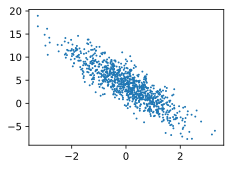

In [4]:

pltutils.set_figsize()
pltutils.plt.scatter(
    features[:, 1].detach().numpy(), labels.detach().numpy(), 1)
print("features.shape:{}".format(features.shape))


In [5]:
def data_iter(batch_size:int, features: t.Tensor, labels: t.Tensor):
    num_examples=len(features)
    indices=list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        batch_indices=t.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices]


# 内存问题
- 在运行的时候，并不是把所有的东西都读进内存，使用yield来实现对内存的随机读取


In [10]:
batch_size=100
for x,y in data_iter(batch_size,features,labels):
    print("x.shape:{},y.shape:{}".format(x.shape,y.shape))

x.shape:torch.Size([100, 2]),y.shape:torch.Size([100, 1])
x.shape:torch.Size([100, 2]),y.shape:torch.Size([100, 1])
x.shape:torch.Size([100, 2]),y.shape:torch.Size([100, 1])
x.shape:torch.Size([100, 2]),y.shape:torch.Size([100, 1])
x.shape:torch.Size([100, 2]),y.shape:torch.Size([100, 1])
x.shape:torch.Size([100, 2]),y.shape:torch.Size([100, 1])
x.shape:torch.Size([100, 2]),y.shape:torch.Size([100, 1])
x.shape:torch.Size([100, 2]),y.shape:torch.Size([100, 1])
x.shape:torch.Size([100, 2]),y.shape:torch.Size([100, 1])
x.shape:torch.Size([100, 2]),y.shape:torch.Size([100, 1])


# 编写模型、参数、损失功能、优化器

In [28]:
#初始化模型参数
class mymodel:
    def __init__(self) -> None:
        
        self.w=t.normal(0,0.01,size=(2,1),requires_grad=True)
        self.b=t.zeros(1,requires_grad=True)
    def forward(self,x):
        return t.matmul(x,self.w)+self.b

    def loss_func(self,y_pred,y_label:t.Tensor):
        return (y_pred-y_label.reshape(y_pred.shape))**2/2
    
    def stochastic_gradient_desent(self,params:t.Tensor,lr,batch_size):
        with t.no_grad():
            for param in params:
                param-=lr*param.grad/batch_size
                param.grad.zero_()

net = mymodel()
lr = 0.03
num_epochs=10
for epoch in range(num_epochs):
    for x,y in data_iter(batch_size,features,labels):
        predict = net.forward(x)
        loss=net.loss_func(predict,y)
        loss.sum().backward()
        net.stochastic_gradient_desent([net.w,net.b],lr=lr,batch_size=32)
    with t.no_grad():
        train_l=net.loss_func(net.forward(features),labels)
        print(f'epoch {epoch+1},loss {float(train_l.mean()):f}')


print(f'w的误差:{net.w-true_w.reshape(net.w.shape)},\r\nb的误差：{net.b-true_b}')


epoch 1,loss 2.401031
epoch 2,loss 0.362445
epoch 3,loss 0.054953
epoch 4,loss 0.008374
epoch 5,loss 0.001309
epoch 6,loss 0.000245
epoch 7,loss 0.000082
epoch 8,loss 0.000057
epoch 9,loss 0.000054
epoch 10,loss 0.000053
w的误差:tensor([[0.0003],
        [0.0005]], grad_fn=<SubBackward0>),
b的误差：tensor([-0.0004], grad_fn=<SubBackward0>)
